# 7DaysOfCode: Dia 3 - Storytelling com Dados do CEAPS

Neste notebook, vamos explorar os dados do CEAPS (Cota para Exercício da Atividade Parlamentar dos Senadores) e criar uma narrativa visual através de gráficos interativos. O objetivo é responder a perguntas chave e identificar padrões interessantes para comunicar nossos resultados de forma clara e eficaz.


## 1. Carregamento dos Dados

Primeiro, carrego o conjunto de dados tratado no dia 1, que foi salvo em formato CSV.


In [1]:
 # Carregar os dados tratados
import pandas as pd
import numpy as np
ceaps_2019_2022 = pd.read_csv('../data/ceaps_2019_2022_tratado.csv', sep=';', decimal=',', encoding='ISO-8859-1')
ceaps_2019_2022.info()
print(ceaps_2019_2022.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69354 entries, 0 to 69353
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ANO                69354 non-null  int64  
 1   MES                69354 non-null  int64  
 2   SENADOR            69354 non-null  object 
 3   TIPO_DESPESA       69354 non-null  object 
 4   CNPJ_CPF           69354 non-null  object 
 5   FORNECEDOR         69354 non-null  object 
 6   DOCUMENTO          69342 non-null  object 
 7   DATA               69354 non-null  object 
 8   DETALHAMENTO       38583 non-null  object 
 9   VALOR_REEMBOLSADO  69354 non-null  float64
 10  COD_DOCUMENTO      69354 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 5.8+ MB
    ANO  MES       SENADOR                                       TIPO_DESPESA  \
0  2019    1  ACIR GURGACZ  Aluguel de imóveis para escritório político, c...   
1  2019    1  ACIR GURGACZ  Aluguel de imóv

## 2. Tratando data
- verifica-se que a data não está no formato correto.


In [2]:
 #Colocando data no formato datetime
ceaps_2019_2022['DATA'] = pd.to_datetime(ceaps_2019_2022['DATA'], format='%Y-%m-%d', errors='coerce')
print(ceaps_2019_2022['DATA'].isnull().sum())
ceaps_2019_2022.info()


0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69354 entries, 0 to 69353
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ANO                69354 non-null  int64         
 1   MES                69354 non-null  int64         
 2   SENADOR            69354 non-null  object        
 3   TIPO_DESPESA       69354 non-null  object        
 4   CNPJ_CPF           69354 non-null  object        
 5   FORNECEDOR         69354 non-null  object        
 6   DOCUMENTO          69342 non-null  object        
 7   DATA               69354 non-null  datetime64[ns]
 8   DETALHAMENTO       38583 non-null  object        
 9   VALOR_REEMBOLSADO  69354 non-null  float64       
 10  COD_DOCUMENTO      69354 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 5.8+ MB


### 2.1 Criando dataset despesas por dia
Irei filtrar o sataset para calcular o valor total gasto diáriamente.

In [3]:
#Agrupando as despesas por dia para 
despesas_por_dia = ceaps_2019_2022.groupby(ceaps_2019_2022['DATA'].dt.date)['VALOR_REEMBOLSADO'].sum().reset_index()
despesas_por_dia['DATA'] = pd.to_datetime(despesas_por_dia['DATA'])
despesas_por_dia.head()


,DATA,VALOR_REEMBOLSADO
0,2019-01-01,10201.92
1,2019-01-02,110927.37
2,2019-01-03,25735.84
3,2019-01-04,36690.14
4,2019-01-05,10885.84


In [4]:
despesas_por_dia.rename(columns={'DATA': 'ds', 'VALOR_REEMBOLSADO': 'y'}, inplace= True)
despesas_por_dia.info()
# Para os modelos irei renomear o campo data para DS(Idependente/Features) e o campo valor_reembolsado para y(variável alvo/target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1461 non-null   datetime64[ns]
 1   y       1461 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


## 3. Forecasting
Escolher modelo para prever quanto os senadores iram gastar nos próximos 3 meses.
Primeiro vou separar entre dados de treino e teste.

In [5]:
treino = despesas_por_dia[1:len(despesas_por_dia)-90] 
teste = despesas_por_dia[len(despesas_por_dia)-90:] 
treino.head()


,ds,y
1,2019-01-02,110927.37
2,2019-01-03,25735.84
3,2019-01-04,36690.14
4,2019-01-05,10885.84
5,2019-01-06,5332.49


In [6]:
teste.head()

,ds,y
1371,2022-10-03,278498.58
1372,2022-10-04,148010.01
1373,2022-10-05,102661.09
1374,2022-10-06,58222.23
1375,2022-10-07,52018.71


### 3.1 [Facebook Prophet](https://facebook.github.io/prophet/?utm_medium=email&_hsenc=p2ANqtz-944sqHxueM8pE1Rcbkgmo6CgMLtNIERMGMH1S5wgWCRTZUPb0PBx-n0Px-S9brJ4enBWNQpCTFXyQ8WpnKdmJuVQ8Y7A&_hsmi=231297784&utm_content=231297784&utm_source=hs_automation)
- A variável independente nesse modelo deve estar no formato timestamp, e como minha variável alvo é quantitativa, o modelo é adequado.
- A versão do meu interpretador Python não reconheceu o Prophet, então segui o passo a passo deste [link](https://ichi.pro/pt/instalando-fbprophet-prophet-para-previsao-de-series-temporais-no-jupyter-notebook-138430470814014) para a construção de um novo ambiente virtual com as dependências necessárias e utilizei como interpretador uma versão menos atualizada do Python.
- Segui com os outros modelos utilizando o mesmo kernel que criei conforme o link acima, chamado de `time_square`, e fiz as instalações das dependências no próprio terminal (`conda install scikit-learn` e `conda install pmdarima`).

In [7]:
from prophet import Prophet
m = Prophet()
m.fit(treino)

c:\Users\LisLima\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
11:50:22 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
 # Previsão
y_predicted = m.make_future_dataframe(periods=90)
forecast = m.predict(y_predicted)

In [9]:
 # Aplicando a métrica Raiz Quadrada do Erro Quadrático Médio para avaliar o modelo
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(teste.y, forecast.yhat.tail(90))) 
rmse


71285.85205320508

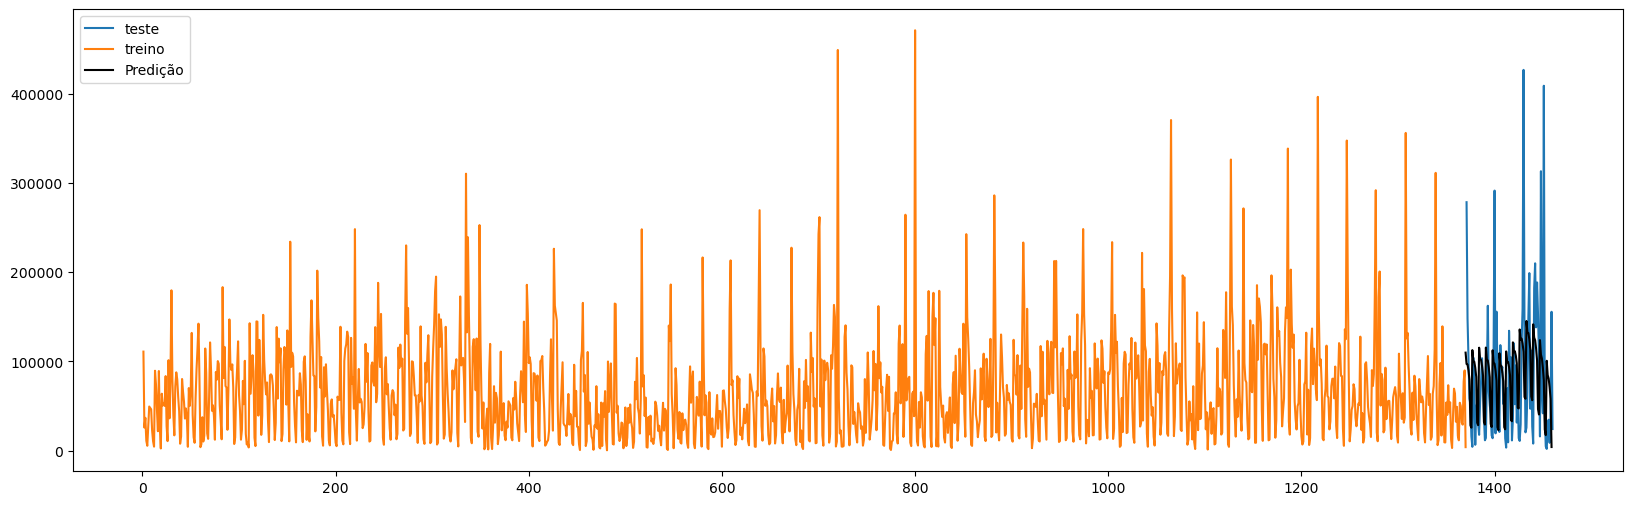

In [10]:
 # Plotando o modelo 
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(teste.y)
plt.plot(treino.y)
plt.plot(forecast.yhat.tail(90),color='black')
plt.legend(['teste', 'treino','Predição'])  # Plotando o teste,treino e predição do modelo


## 3.2 [Regressão Linear](https://scikit-learn.org/stable/modules/linear_model.html#linear-regression)

Utilizamos a regressão linear para prever os valores futuros da cota parlamentar. A regressão linear é um método estatístico que modela a relação entre uma variável dependente(alvo) (y) e uma variável independente (X) ajustando uma linha reta (modelo linear) aos dados observados.

Para utilizar datas como variável independente em modelos de regressão, é necessário convertê-las para um formato numérico. Neste caso, convertemos as datas em dias desde o início da série temporal para que o modelo possa processá-las corretamente.


In [11]:
from sklearn.linear_model import LinearRegression
df = despesas_por_dia.copy()
# Converta a coluna 'ds' para o formato numérico (dias desde a data inicial)
df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days
# Verifique a transformação
print(df.head())




          ds          y  days_since_start
0 2019-01-01   10201.92                 0
1 2019-01-02  110927.37                 1
2 2019-01-03   25735.84                 2
3 2019-01-04   36690.14                 3
4 2019-01-05   10885.84                 4


In [12]:

from sklearn.model_selection import train_test_split
# Prepare os dados para a regressão linear
X = df[['days_since_start']]
y = df['y']

# Divida os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie e ajuste o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Faça previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcule o RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 59182.11295140329


In [13]:
# Faça previsões usando o modelo ajustado no conjunto completo
df['regression_line'] = model.predict(X)
# Gere previsões futuras para os próximos 90 dias (aproximadamente 3 meses)
future_days = np.arange(df['days_since_start'].max() + 1, df['days_since_start'].max() + 91).reshape(-1, 1)
future_predictions = model.predict(future_days)

c:\Users\LisLima\anaconda3\envs\time_series\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


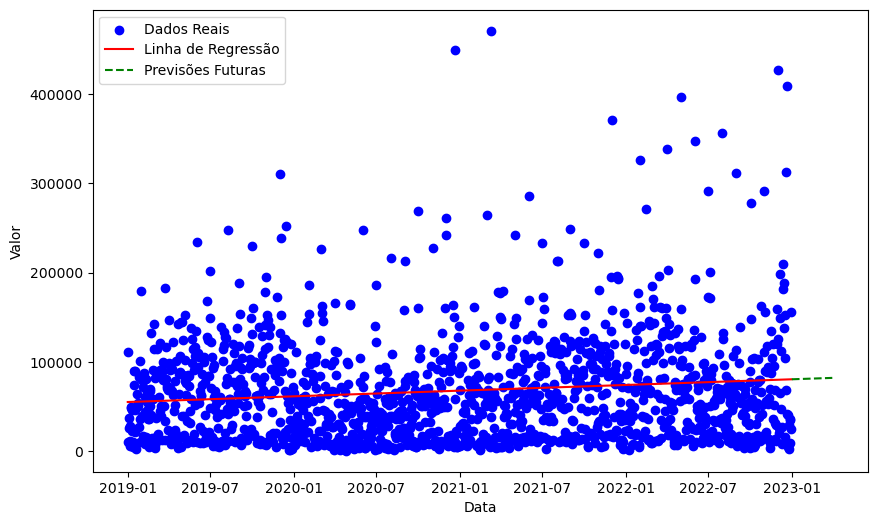

In [14]:
# Plote o gráfico
future_dates = pd.date_range(df['ds'].max() + pd.Timedelta(days=1), periods=90)

plt.figure(figsize=(10, 6))
plt.scatter(df['ds'], df['y'], label='Dados Reais', color='blue')
plt.plot(df['ds'], df['regression_line'], label='Linha de Regressão', color='red')
plt.plot(future_dates, future_predictions, linestyle='--', color='green', label='Previsões Futuras')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()



## 3.3 [Auto ARIMA](https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pmdarima.arima.auto_arima.html)

Utilizei o modelo Auto ARIMA para prever os valores futuros da cota parlamentar. O ARIMA é uma técnica de modelagem de séries temporais que combina três componentes: autoregressão (AR), diferenciação integrada (I) e média móvel (MA). O `pmdarima` facilita a seleção do melhor modelo ARIMA ao automatizar o processo de ajuste de parâmetros (p, d, q) para os dados.

O Auto ARIMA permite determinar automaticamente os melhores parâmetros para o modelo, tornando o processo de modelagem mais eficiente.


In [15]:
from pmdarima import auto_arima
model = auto_arima(
    y=treino['y'],
    seasonal=False,  # Tente desativar a sazonalidade
    stepwise=True,
    trace=True
)

# Fazer previsões
forecast = model.predict(n_periods=len(teste))
forecast_series = pd.Series(forecast, index=teste.index)

# Calcular o RMSE
rmse = np.sqrt(mean_squared_error(teste['y'], forecast_series))
# Exibir o RMSE
print(f'RMSE: {rmse:.2f}')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33704.366, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34291.813, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34184.810, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33862.874, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34289.816, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33713.806, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33739.672, Time=0.81 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=33708.000, Time=1.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=33716.078, Time=1.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33754.294, Time=0.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=33724.848, Time=1.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33740.220, Time=0.99 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=33700.623, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[0]  

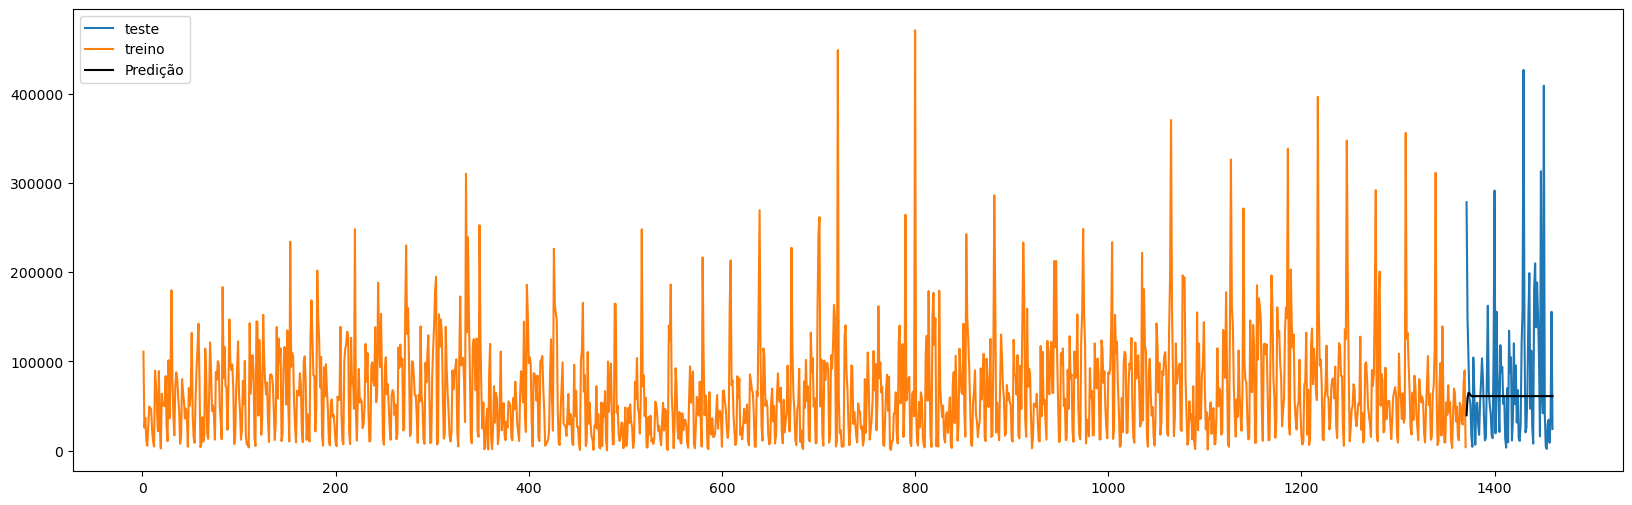

In [16]:
# Plotar os resultados
plt.figure(figsize=(20, 6))
plt.plot(teste.y)
plt.plot(treino.y)
plt.plot(forecast, color = "black")
plt.legend(['teste', 'treino','Predição'])  # Plotando o teste,treino e predição do modelo
